In [1]:
import pandas as pd
import numpy as np
import gym

from itertools import product
import matplotlib.pyplot as plt

In [2]:
# +1.5 if natural is True
env = gym.make('Blackjack-v1', natural=True)

In [3]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [4]:
env.action_space

Discrete(2)

## Часть первая - наивная стратегия и Q-Learning

### Оценка среднего выигрыша методом Монте-Карло

In [5]:
MIN_COUNT = 4
MAX_COUNT = 32
MAX_ITER = 100_000


STATES = list(zip(
    range(MIN_COUNT, MAX_COUNT),
    range(1, 11),
    [True, False],
))

In [6]:
def naive_strategy():
    strategy = np.ones(MAX_COUNT).astype(int)
    strategy[19:22] = 0
    return strategy


def one_game_reward(strategy):
    finished = False
    reward = 0
    state = env.reset()[0]
    
    while not finished:
        action = strategy[state[0]]
        state, cur_reward, finished, _, _ = env.step(action)
        reward += cur_reward

    return reward


def estimate_reward(max_iter=MAX_ITER):
    strategy = naive_strategy()
    return np.mean([one_game_reward(strategy) for i in range(max_iter)])

print(f"Estimated reward for naive strategy: {estimate_reward()}")

Estimated reward for naive strategy: -0.19934


### Q-learning

In [7]:
env = gym.make('Blackjack-v1', natural=True)
env.natural = True

STATES = list(product(
    range(MIN_COUNT, MAX_COUNT),
    range(1, 11),
    [True, False],
))


# Оптимальные параметры
EPS = 0.85
GAMMA = 0.9
ALPHA = 1e-3

# Сюда будем сохранять историю
rewards = []


def q_learning_strategy():
    best_choices = np.argmax(list(Q.values()), axis=1)
    return dict(zip(STATES, best_choices))


def one_game_reward(strategy):
    finished = False
    reward = 0
    state = env.reset()[0]
    
    while not finished:
        action = strategy[state]
        state, cur_reward, finished, _, _ = env.step(action)
        reward += cur_reward

    return reward


def estimate_reward(max_iter=MAX_ITER):
    strategy = q_learning_strategy()
    return np.mean([one_game_reward(strategy) for i in range(max_iter)])



# Реализация Q-Learning
def pick_action(state):
    if np.random.random() > 1 - EPS:
        return np.random.choice([0, 1])
    return np.argmax(Q[state])


def Q_learning(max_iter=MAX_ITER):
    for i in range(max_iter):
        state = env.reset()[0]
        finished = False
        while not finished:
            action = pick_action(state)
            new_state, reward, finished, _, _ = env.step(action)
            Q[state][action] += ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[state][action])
            state = new_state
            
        if (i + 1) % 1000 == 0:
            rewards.append(estimate_reward(max_iter=10_000))
            
            

# начальная инициализация и старт обучения
Q = dict(zip(STATES, np.zeros((len(STATES), 2))))
Q_learning()

В конце посмотрим какой получился средний reward. Видим, что довольно значительно смогли побить бейзлайн с наивной стратегией.

In [8]:
estimate_reward()

-0.05202

Отобразим историю средних выигрышей

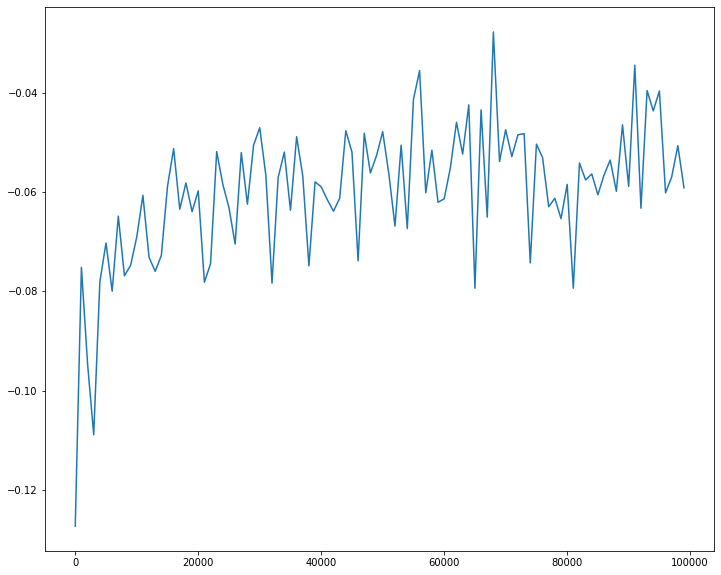

In [9]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(0, MAX_ITER, 1000), rewards);

## Часть вторая, удвоенная